In [2]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [3]:
data_path = "/Users/jihye/Projects/research/01_practice_images/NLST/100002/01-02-1999-NA-NLST-LSS-55322/1.000000-0OPAGELSPLUSD3602.512080.00.11.5-35858/"
output_path = working_path = "/Users/jihye/Projects/research/01_practice_images"
g = glob(data_path + '/*.dcm')

In [4]:
# loop over image files and store everything into a list
def load_scan(path):    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] # os.listdir() gets list of all files and directories
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        # ImagePositionPatient returns x,y,z coor of upper left hand corner
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        # SliceLocation returns relative position of image plance in mm
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        # unit of distance in z-dir per slice (image)
        # less than 2mm; in order to optimize as much info
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans): # input is output from load_scans
    
    # pixel_array 
    # stack: join sequence of arrays along a new axis
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # b in relationship between stored values SV and output units (m*SV + b)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [5]:
# resampling
print("Slice Thickness: %f" % patient[0].SliceThickness)

# PixelSpacing returns the physical distance in mm between center of each pixel
# first value is space between rows (vertical distance); second value is space between col (horizontal distance)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

# diff voxel resolution between patients; resample it to make it isovoxel
id = 0
imgs_to_process = np.flip(np.load(output_path+'/' + 'fullimages_{}.npy'.format(id)))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # change each item in list to float; create numpy array from list
    # spacing = list of distance between pixels in z, x, y directions
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing # array 
    new_real_shape = image.shape * resize_factor #shape: returns dimensions of image
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.703125, 0.703125) 
Shape before resampling	 (126, 512, 512)
Shape after resampling	 (315, 360, 360)


In [6]:
# 3D plotting
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface") 
    # original axes is 0,1,2; tranposed so axis 0 takes place of axis 2 and vice versa
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    # marching cubtes algorithm is used to generate 3D mesh from dataset
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) # iterator of tuples where 1st items are paired, 2nd items are paired, etc
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
    # colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)


def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    
    ax.invert_yaxis()
    
    plt.show()


Transposing surface
Calculating surface
Drawing


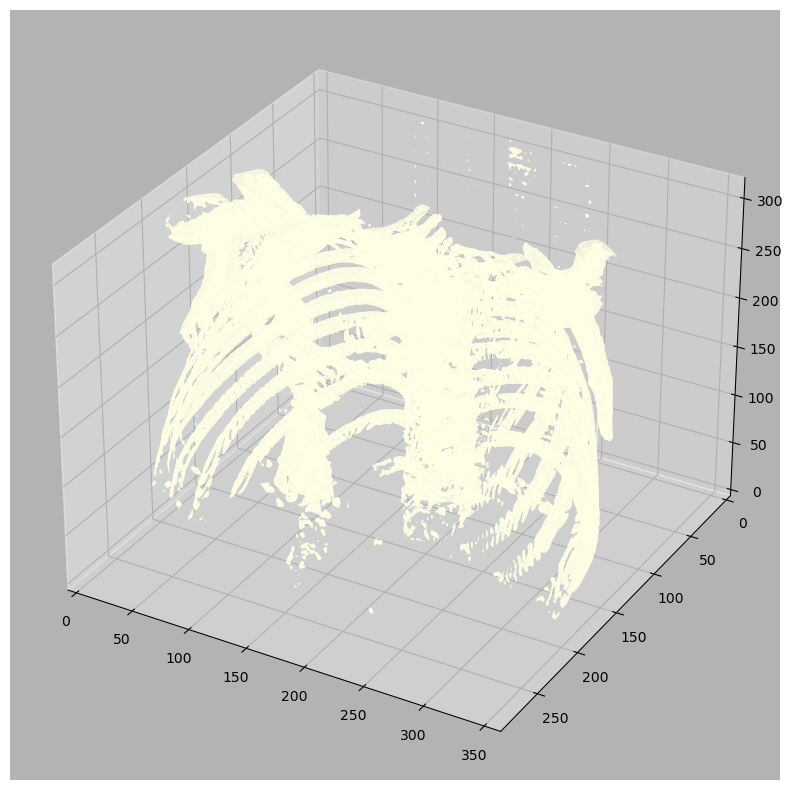

In [7]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plt_3d(v, f)